# Pyro AR2 Example

In [1]:
!pip install numpyro==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import argparse
import os
import time

import jax
from jax import lax
from jax import random
import jax.numpy as jnp

import numpy as np
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from pyro.ops.stats import quantile
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.handlers import mask


import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numpyro.set_platform("cpu")
numpyro.set_host_device_count("4")
# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Data

In [3]:
def get_weather_data(df):
    """Extract the columns that are the weather data we would like to use"""
    return df[['temp', 'temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']].copy()

def get_energy_data(df):
    """Extract the columns that are the energy data we would like to use"""
    return  df[['generation biomass','generation fossil', 'generation hydro', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar',
        'generation total', 'generation waste', 'generation wind onshore']].copy()

In [4]:
# set variables describing how much data to use
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing
aggregation_level = "D" # aggregation level of the data, D = daily, W = weekly, M = monthly

# read the data that has previously (in last assignment, see data notebook) been preprocessed
df = pd.read_csv("preprocessed_data/df.csv")
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)

# group by date and take the mean as we have multiple measurements per day due to having data from 5 different cities in Spain
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None

# aggregate data, can be commented out to use all data
# df = df.asfreq(aggregation_level) 
df = df.resample(aggregation_level).mean()
# df = df.groupby(df.index.date).mean().reset_index()

# extract the columns that we would like to use
dfW = get_weather_data(df)
dfE = get_energy_data(df)

# define start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)


# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfE.columns) + list(dfW.columns) + ["price_actual"], index = df.index)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting

Number of observations: 1462
Number of training observations: 1316
Number of test observations: 146


## Model

In [47]:
def AR_model(obs, order, T_forecast=0):
    # Initialization of ys for the carry according to the given order of the AR
    y0 = numpyro.sample("y0", dist.Normal(1, 0), sample_shape=(order, 1)) 
    timesteps = jnp.arange(len(y0), obs.shape[0] + T_forecast)

    beta = numpyro.sample("beta", dist.Normal(0., 1.), sample_shape=(len(y0),))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(1.))

    def transition(carry, t):
        ys = carry
        m_t = beta@ys
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = jnp.concatenate([jnp.array([y_t]), ys[:-1]])
        return carry, y_t

    with numpyro.handlers.condition(data={"y": obs[len(y0):]}):
        _, ys = scan(transition, y0 , timesteps)
    if T_forecast > 0:
        numpyro.deterministic("y_pred", ys[-T_forecast:])

In [20]:
def AR_input_model(y, X, order, T_forecast=0):
    # Initialization of ys for the carry according to the given order of the AR
    init = y[jnp.arange(order-1, -1, -1)]
    timesteps = jnp.arange(len(init), y.shape[0] + T_forecast)


    alpha = numpyro.sample("alpha", dist.Normal(0., 1.), sample_shape=(len(init),))
    beta = numpyro.sample("beta", dist.Normal(0., 1.), sample_shape=(X.shape[1],1))
    const = numpyro.sample("const", dist.Normal(0., 1.))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(1.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(y.shape[0]+T_forecast-len(init),))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))

    def transition(carry, t):
        ys = carry
        m_t = alpha@ys + X[t]@beta + tau*noises[t]
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = jnp.concatenate([jnp.array([y_t]), ys[:-1]])
        return carry, y_t

    with numpyro.handlers.condition(data={"y": y[len(init):]}):
        _, ys = scan(transition, init, timesteps)
        
    if T_forecast > 0:
        numpyro.deterministic("y_pred", ys[-T_forecast:])

## Inference

In [73]:
start = time.time()
sampler = numpyro.infer.NUTS(AR_model)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_warmup=1000,
    num_samples=5000,
    num_chains=4,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

x_train = jnp.array(covariates[:T1])
y_train = jnp.array(y[:T1])
mcmc.run(jax.random.PRNGKey(0), obs=y_train, order=1)
mcmc.print_summary()
print("\nMCMC elapsed time:", time.time() - start)

posterior_samples = mcmc.get_samples()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -0.38      1.38     -0.53     -1.85      1.37       nan 12407331.00
     sigma      0.80      0.47      0.85      0.16      1.35       nan 7506218.93
   y0[0,0]      0.19      1.19     -0.03     -1.08      1.88      2.00 13518850.00

Number of divergences: 20000

MCMC elapsed time: 13.036958694458008


In [84]:
forecast_N = 4
predictive = Predictive(AR_model, posterior_samples, return_sites=["y_pred"])
forecast_marginal = predictive(random.PRNGKey(1), obs=y_train, order=1, T_forecast=forecast_N)[
    "y_pred"
]

In [85]:
y_test = jnp.array(y[T1:T1+forecast_N])
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 33.48, rmse: 3.39


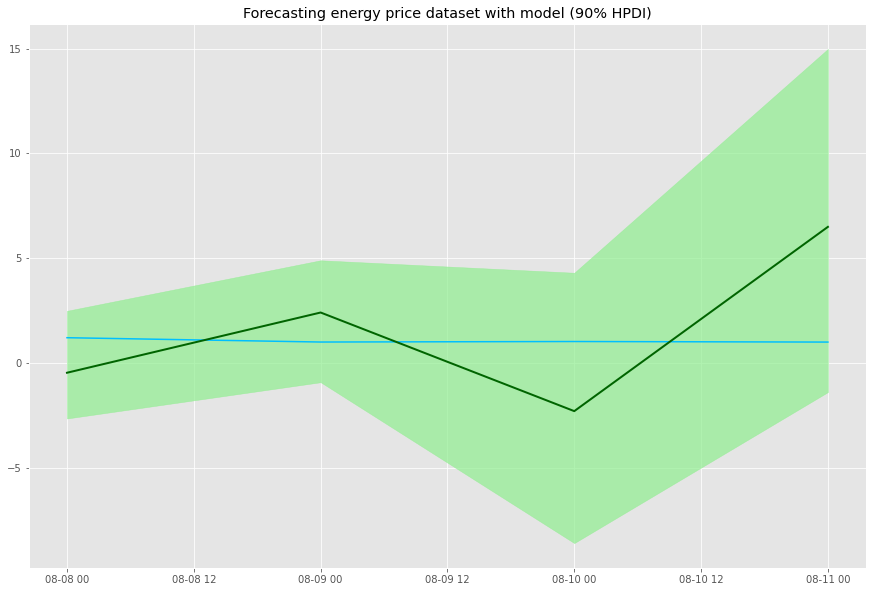

In [89]:
plt.figure(figsize=(15, 10))
plt.plot(dates[T1:T1+forecast_N], y[T1:T1+forecast_N].numpy().flatten(), 'deepskyblue')
t_future = dates[T1:T1+forecast_N]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2, color='darkgreen')
plt.fill_between(t_future, hpd_low.flatten(), hpd_high.flatten(), alpha=0.7, color='lightgreen')
plt.title("Forecasting energy price dataset with model (90% HPDI)")
plt.show()

In [53]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted.flatten(), trues.flatten())[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [54]:
corr, mae, rae, rmse, r2 = compute_error(y_test, y_pred)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.106
MAE: 978469726220903207504082632704.00000
RMSE: inf
R2: 0.000
